## Lending Club Feature Selection

In [1]:
# import libraries 
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns

%matplotlib inline

In [2]:
# Get the data
data = pd.read_csv('lending_club_loans.csv', skiprows=1, low_memory=False)
data.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,1077501,1296599.0,5000.0,5000.0,4975.0,36 months,10.65%,162.87,B,B2,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
1,1077430,1314167.0,2500.0,2500.0,2500.0,60 months,15.27%,59.83,C,C4,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
2,1077175,1313524.0,2400.0,2400.0,2400.0,36 months,15.96%,84.33,C,C5,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
3,1076863,1277178.0,10000.0,10000.0,10000.0,36 months,13.49%,339.31,C,C1,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
4,1075358,1311748.0,3000.0,3000.0,3000.0,60 months,12.69%,67.79,B,B5,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN


### Delete Features with Null Values

In [3]:
# Find features where all values are null
print('Data shape:', data.shape)
print('Columns where all values are null:', len(data.columns[data.isnull().all()]))
print('Columns with values:', len(data.columns) - len(data.columns[data.isnull().all()]))
print('Columns with no null values:', len(data.columns[data.notnull().all()]))

Data shape: (42538, 115)
Columns where all values are null: 54
Columns with values: 61
Columns with no null values: 1


Text(0.5,1,'Percentage of Null Values')

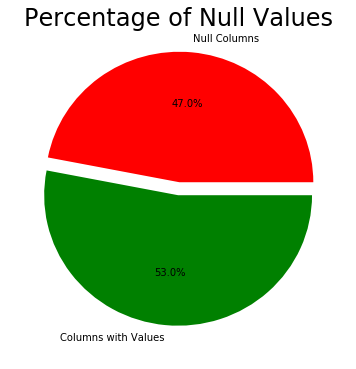

In [4]:
# Pie chart of null features
values = [len(data.columns[data.isnull().all()]), 
          len(data.columns) - len(data.columns[data.isnull().all()])]
colors = ['r', 'g']
labels = ['Null Columns', 'Columns with Values']
explode = (0.1, 0)
fig = plt.figure(figsize=(6, 6))
plt.pie(values, colors=colors, labels=labels,
explode=explode, autopct='%1.1f%%',
counterclock=True, shadow=False)
plt.title('Percentage of Null Values', fontsize=24)

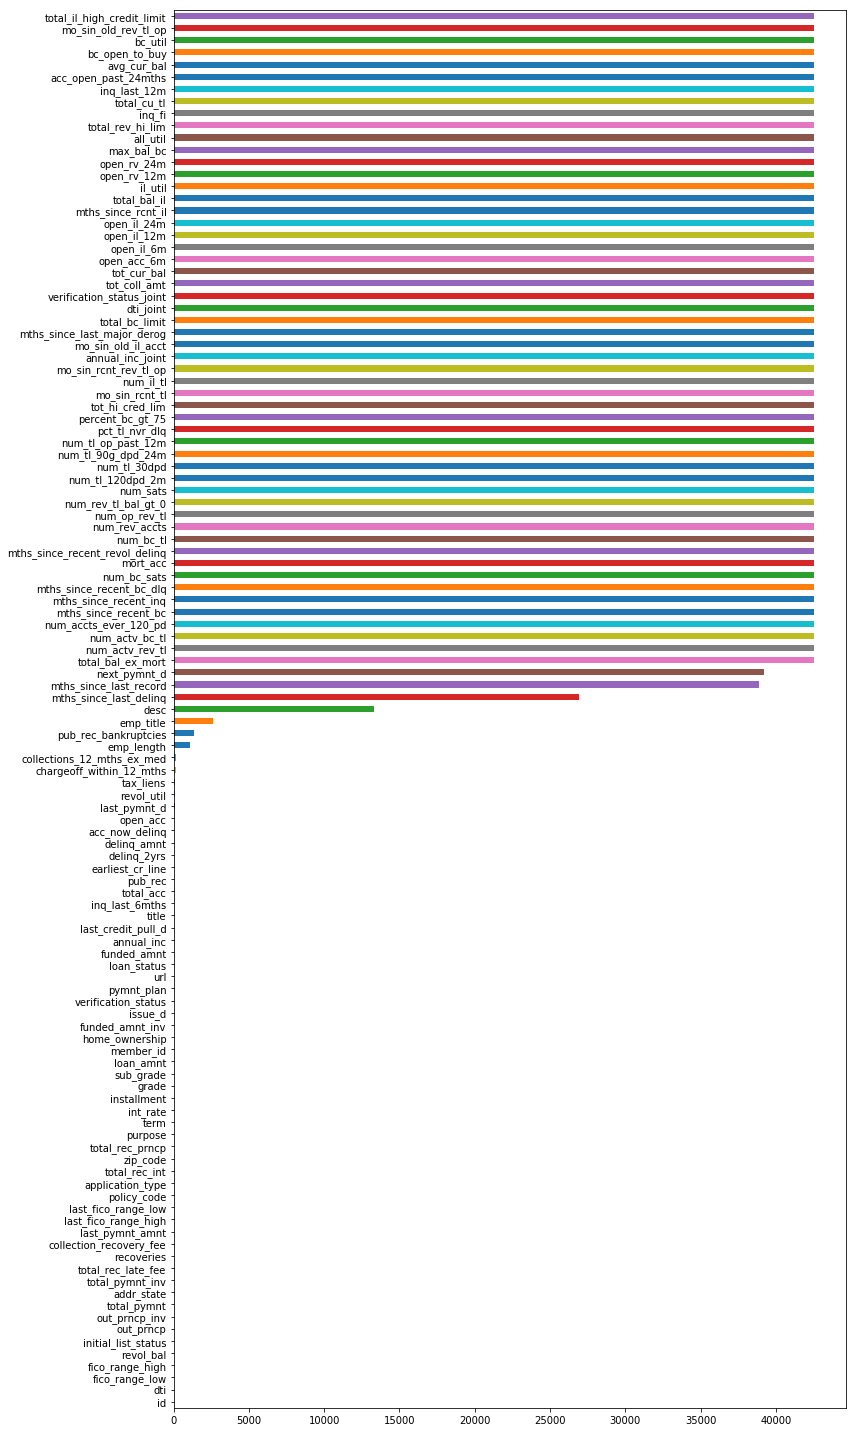

In [5]:
# Bar chart of null features
data.isnull().sum().sort_values().plot.barh(figsize=(12,20))
plt.tight_layout()

In [6]:
# Drop null features
print(data.shape)
dataset = data.dropna(how='all', axis='columns')
print(dataset.shape)

(42538, 115)
(42538, 61)


In [7]:
# Show number of null values for each feature
dataset.isnull().sum()

id                                0
member_id                         3
loan_amnt                         3
funded_amnt                       3
funded_amnt_inv                   3
term                              3
int_rate                          3
installment                       3
grade                             3
sub_grade                         3
emp_title                      2629
emp_length                     1115
home_ownership                    3
annual_inc                        7
verification_status               3
issue_d                           3
loan_status                       3
pymnt_plan                        3
url                               3
desc                          13296
purpose                           3
title                            16
zip_code                          3
addr_state                        3
dti                               3
delinq_2yrs                      32
earliest_cr_line                 32
fico_range_low              

In [8]:
# Delete rows where all values are null (except for id)
rows_all_null = dataset[dataset.drop(['id'], axis=1).isnull().all(1)].index.values
print(rows_all_null)
dataset.drop(dataset.index[[rows_all_null]], inplace=True)
print(dataset.shape)
dataset.isnull().sum()

[39786 42536 42537]
(42535, 61)


/opt/conda/lib/python3.6/site-packages/pandas/core/indexes/base.py:2095: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = getitem(key)
/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


id                                0
member_id                         0
loan_amnt                         0
funded_amnt                       0
funded_amnt_inv                   0
term                              0
int_rate                          0
installment                       0
grade                             0
sub_grade                         0
emp_title                      2626
emp_length                     1112
home_ownership                    0
annual_inc                        4
verification_status               0
issue_d                           0
loan_status                       0
pymnt_plan                        0
url                               0
desc                          13293
purpose                           0
title                            13
zip_code                          0
addr_state                        0
dti                               0
delinq_2yrs                      29
earliest_cr_line                 29
fico_range_low              

### Remove Columns Due to Data Leakage

Don't use columns that we won't have for predictions (data leakage). We don't want our model to be learning from features that will change in the future, or won't be available when the predictions are made. Data leakage can cause the model to overfit.

In [9]:
# Track cols_dropped and columns_to_drop from here forward
cols_dropped = []
columns_to_drop = ['id','member_id','funded_amnt','funded_amnt_inv',
            'int_rate','sub_grade','emp_title','issue_d','url','desc',
            'zip_code','total_pymnt','total_pymnt_inv',
             'total_rec_prncp','total_rec_int',
             'total_rec_late_fee','recoveries',
             'collection_recovery_fee','last_pymnt_d','last_pymnt_amnt']

print(dataset.shape)
dataset.drop(labels=columns_to_drop, axis=1, inplace=True)
print(dataset.shape)

(42535, 61)
(42535, 41)


/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


### Engineer the Target

In [10]:
# Values in loan_status
dataset['loan_status'].value_counts()

Fully Paid                                             33586
Charged Off                                             5653
Does not meet the credit policy. Status:Fully Paid      1988
Does not meet the credit policy. Status:Charged Off      761
Current                                                  513
In Grace Period                                           16
Late (31-120 days)                                        12
Late (16-30 days)                                          5
Default                                                    1
Name: loan_status, dtype: int64

In [11]:
# Rename loan_status to target and show shapes before mapping
dataset.rename(columns={'loan_status': 'target'}, inplace=True)
print('dataset shape before mapping', dataset.shape)
rows_start=dataset.shape[0]

# Map the target. Fully Paid and Charged Off are best labels for predictions
dataset = dataset[(dataset['target'] == 'Fully Paid') |
                            (dataset['target'] == 'Charged Off')]

mapping_dictionary = {'target':{ 'Fully Paid': 1, 'Charged Off': 0}}
dataset = dataset.replace(mapping_dictionary)

# Show shapes after mapping
print('dataset shape after mapping', dataset.shape)
print('rows deleted', rows_start - dataset.shape[0])

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


dataset shape before mapping (42535, 41)
dataset shape after mapping (39239, 41)
rows deleted 3296


### Engineer FICO Score

In [12]:
# Create a fico_average feature and update the data dictionary preview
dataset['fico_average'] = (dataset['fico_range_high'] + dataset['fico_range_low']) / 2
print(dataset.shape)
drop_cols = ['fico_range_low','fico_range_high','last_fico_range_low','last_fico_range_high']
dataset.drop(drop_cols, axis=1, inplace=True)
cols_dropped.extend(drop_cols)
print(dataset.shape)
dataset['fico_average'].head()

(39239, 42)
(39239, 38)


0    737.0
1    742.0
2    737.0
3    692.0
5    732.0
Name: fico_average, dtype: float64

### Review and Delete

In [13]:
# Show notnull() columns and column types
print('Columns with no null values:', len(dataset.columns[dataset.notnull().all()]))
print('Columns with null values:', len(dataset.columns[dataset.isnull().any()]))

Columns with no null values: 27
Columns with null values: 11


In [14]:
# Show the count of notnull values
nonulls = []
for col in dataset.columns:
    if dataset[col].notnull().sum() == dataset.shape[0]:
        nonulls.append(col)
        print('{: >30} count: {}, {}'.format(col, dataset[col].notnull().sum(), dataset[col].dtype,))
        
print(dataset[nonulls].dtypes.value_counts())

                     loan_amnt count: 39239, float64
                          term count: 39239, object
                   installment count: 39239, float64
                         grade count: 39239, object
                home_ownership count: 39239, object
                    annual_inc count: 39239, float64
           verification_status count: 39239, object
                        target count: 39239, int64
                    pymnt_plan count: 39239, object
                       purpose count: 39239, object
                    addr_state count: 39239, object
                           dti count: 39239, float64
                   delinq_2yrs count: 39239, float64
              earliest_cr_line count: 39239, object
                inq_last_6mths count: 39239, float64
                      open_acc count: 39239, float64
                       pub_rec count: 39239, float64
                     revol_bal count: 39239, float64
                     total_acc count: 39239, float64
   

In [15]:
# Show the count of 'with null' values
original_nulls = pd.DataFrame(columns=['Feature','null_count','type'])
withnulls = []
for col in dataset.columns:
    if dataset[col].isnull().sum() > 0:
        withnulls.append(col)
#         print('{: >30} count: {}, {}'.format(col, dataset[col].isnull().sum(), dataset[col].dtype,))
        original_nulls = original_nulls.append({'Feature': col, 'null_count': dataset[col].isnull().sum(), 'type': dataset[col].dtype}, ignore_index=True)
        
# print(dataset[withnulls].dtypes.value_counts())
original_nulls

,Feature,null_count,type
0,emp_length,1057,object
1,title,11,object
2,mths_since_last_delinq,25352,float64
3,mths_since_last_record,36466,float64
4,revol_util,50,object
5,next_pymnt_d,39239,object
6,last_credit_pull_d,2,object
7,collections_12_mths_ex_med,56,float64
8,chargeoff_within_12_mths,56,float64
9,pub_rec_bankruptcies,697,float64


In [16]:
# Show the percentage of null values 
for col in dataset.columns:
    if dataset[col].isnull().mean() > 0:
        print('{: >30} {}'.format(col, dataset[col].isnull().mean()))

                    emp_length 0.026937485664772293
                         title 0.0002803333418282831
        mths_since_last_delinq 0.6460918983664211
        mths_since_last_record 0.9293305130100156
                    revol_util 0.0012742424628558323
                  next_pymnt_d 1.0
            last_credit_pull_d 5.096969851423329e-05
    collections_12_mths_ex_med 0.001427151558398532
      chargeoff_within_12_mths 0.001427151558398532
          pub_rec_bankruptcies 0.0177629399322103
                     tax_liens 0.0009939091210275492


In [17]:
# Drop columns with missing values > 60
columns_to_drop = ['mths_since_last_delinq','mths_since_last_record','next_pymnt_d']
dataset.drop(labels=columns_to_drop, axis=1, inplace=True)
cols_dropped.extend(columns_to_drop)
print(dataset.shape)

(39239, 35)


### Constant and Quasi-constant Values

In [18]:
# Check for features that have only one value
constant_features = [
    feat for feat in dataset.columns if len(dataset[feat].unique()) == 1
]

print('{} constant features:'.format(len(constant_features)))
print(dataset[constant_features].columns)

7 constant features:
Index(['initial_list_status', 'out_prncp', 'out_prncp_inv', 'policy_code',
       'application_type', 'acc_now_delinq', 'delinq_amnt'],
      dtype='object')


In [19]:
# Drop the constant features
print(dataset.shape)
dataset.drop(labels=constant_features, axis=1, inplace=True)
cols_dropped.extend(constant_features)
print(dataset.shape)

(39239, 35)
(39239, 28)


In [20]:
# Check for features that have only zero values but have null values
constant_features = [
    feat for feat in dataset.columns if len(dataset[feat].fillna(0).unique()) == 1
]

print('length and # of constants with null values:', len(constant_features), constant_features)

for feat in constant_features:
    print('Constant and number of constants: {}, {}; Isnull counts: {}'.format(dataset[feat].unique()[0], 
                                                                        dataset[feat].value_counts()[0],
                                                                        dataset[feat].isnull().sum()))
    
print(dataset.shape)

length and # of constants with null values: 3 ['collections_12_mths_ex_med', 'chargeoff_within_12_mths', 'tax_liens']
Constant and number of constants: 0.0, 39183; Isnull counts: 56
Constant and number of constants: 0.0, 39183; Isnull counts: 56
Constant and number of constants: 0.0, 39200; Isnull counts: 39
(39239, 28)


In [21]:
# Drop features that contain zero and null values
print(dataset.shape)
dataset.drop(labels=constant_features, axis=1, inplace=True)
cols_dropped.extend(constant_features)
print(dataset.shape)

(39239, 28)
(39239, 25)


In [22]:
# Check  for Quasi Constant Values, don't count null values
for col in dataset.columns.sort_values():
    if (len(dataset[col].unique()) < 4):
        print(dataset[col].value_counts())
        print()

n    39238
y        1
Name: pymnt_plan, dtype: int64

1    33586
0     5653
Name: target, dtype: int64

 36 months    29096
 60 months    10143
Name: term, dtype: int64

Not Verified       16845
Verified           12526
Source Verified     9868
Name: verification_status, dtype: int64



In [23]:
# Drop columns with constant / quasi constant values
print(dataset.shape)
columns_to_drop = ['pymnt_plan']
dataset.drop(labels=columns_to_drop, axis=1, inplace=True)
cols_dropped.extend(columns_to_drop)
print(dataset.shape)

(39239, 25)
(39239, 24)


In [24]:
# For large datasets
duplicated_feat = []
for i in range(0, len(dataset.columns)):
    if i % 10 == 0:  # Keep track of the loop
        print('loop tracker', i)

    col_1 = dataset.columns[i]

    for col_2 in dataset.columns[i + 1:]:
        if dataset[col_1].equals(dataset[col_2]):
            duplicated_feat.append(col_2)
            
# Number of duplicated features
print('Number of duplicated features', len(set(duplicated_feat)))

loop tracker 0
loop tracker 10
loop tracker 20
Number of duplicated features 0


In [25]:
print('Columns dropped:')
print(cols_dropped)
print()
print('Columns kept:')
print(dataset.drop('target', axis=1).columns.values.tolist())

Columns dropped:
['fico_range_low', 'fico_range_high', 'last_fico_range_low', 'last_fico_range_high', 'mths_since_last_delinq', 'mths_since_last_record', 'next_pymnt_d', 'initial_list_status', 'out_prncp', 'out_prncp_inv', 'policy_code', 'application_type', 'acc_now_delinq', 'delinq_amnt', 'collections_12_mths_ex_med', 'chargeoff_within_12_mths', 'tax_liens', 'pymnt_plan']

Columns kept:
['loan_amnt', 'term', 'installment', 'grade', 'emp_length', 'home_ownership', 'annual_inc', 'verification_status', 'purpose', 'title', 'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'last_credit_pull_d', 'pub_rec_bankruptcies', 'fico_average']


In [26]:
# Review features kept
features_kept = pd.DataFrame(columns=['Feature','null_count','type'])
numerical_with_na = []
categorical_with_na= []

for col in dataset.columns:
    features_kept = features_kept.append({'Feature': col, 'null_count': dataset[col].isnull().sum(), 'type': dataset[col].dtype}, ignore_index=True)
    if dataset[col].isnull().sum() > 0 and dataset[col].dtype != 'object':
        numerical_with_na.append(col)
    if dataset[col].isnull().sum() > 0 and dataset[col].dtype == 'object':
        categorical_with_na.append(col)
       
print(dataset.shape)
print('numerical with na:', numerical_with_na)
print('categorical with na:', categorical_with_na)
print('numerical without na:', dataset.drop('target', axis=1)._get_numeric_data().drop(numerical_with_na, axis=1).columns.values.tolist())
print('categorical without na:', dataset.select_dtypes(include='object').drop(categorical_with_na, axis=1).columns.values.tolist())
print(features_kept)

(39239, 24)
numerical with na: ['pub_rec_bankruptcies']
categorical with na: ['emp_length', 'title', 'revol_util', 'last_credit_pull_d']
numerical without na: ['loan_amnt', 'installment', 'annual_inc', 'dti', 'delinq_2yrs', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal', 'total_acc', 'fico_average']
categorical without na: ['term', 'grade', 'home_ownership', 'verification_status', 'purpose', 'addr_state', 'earliest_cr_line']
                 Feature null_count     type
0              loan_amnt          0  float64
1                   term          0   object
2            installment          0  float64
3                  grade          0   object
4             emp_length       1057   object
5         home_ownership          0   object
6             annual_inc          0  float64
7    verification_status          0   object
8                 target          0    int64
9                purpose          0   object
10                 title         11   object
11            addr_state 

In [27]:
# divide train and test
from sklearn.model_selection import train_test_split

X = dataset.drop('target', axis=1)
y = dataset.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)  # set the seed
train = pd.DataFrame(data=X_train, columns=dataset.columns)
train['target'] = y_train
test = pd.DataFrame(data=X_test, columns=dataset.columns)
test['target'] = y_test

# export features kept as lending_club_selected_features.csv
train.to_csv (r'lending_club_selected_features_train.csv', index = None, header=True)
test.to_csv (r'lending_club_selected_features_test.csv', index = None, header=True)
# r takes care of symbols within the path name such as the backslash symbol

# did it work?
# Get the data
features = pd.read_csv('lending_club_selected_features_test.csv')
print(features.shape)
features.head()

(7848, 24)


,loan_amnt,term,installment,grade,emp_length,home_ownership,annual_inc,verification_status,target,purpose,...,earliest_cr_line,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,last_credit_pull_d,pub_rec_bankruptcies,fico_average
0,4200.0,36 months,145.02,C,1 year,OWN,27996.0,Not Verified,1,debt_consolidation,...,May-1987,0.0,13.0,0.0,6209.0,62.5%,26.0,Mar-2011,0.0,662.0
1,10000.0,36 months,342.29,D,7 years,RENT,67000.0,Verified,1,debt_consolidation,...,Nov-1994,1.0,6.0,0.0,9583.0,77.3%,12.0,Feb-2013,0.0,682.0
2,6000.0,36 months,203.59,C,1 year,MORTGAGE,48000.0,Source Verified,1,major_purchase,...,Dec-1998,0.0,15.0,0.0,13612.0,89.5%,41.0,Sep-2016,0.0,672.0
3,10000.0,36 months,328.06,B,2 years,RENT,41004.0,Verified,1,home_improvement,...,Aug-2001,2.0,11.0,0.0,9042.0,16.2%,17.0,Nov-2011,0.0,722.0
4,15600.0,60 months,379.04,C,< 1 year,RENT,43000.0,Not Verified,1,debt_consolidation,...,Jun-2004,2.0,5.0,0.0,8803.0,64.3%,7.0,Aug-2015,0.0,712.0


In [28]:
features._get_numeric_data().describe()

,loan_amnt,installment,annual_inc,target,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,total_acc,pub_rec_bankruptcies,fico_average
count,7848.000000,7848.000000,7.848000e+03,7848.000000,7848.000000,7848.000000,7848.000000,7848.000000,7848.000000,7848.000000,7848.000000,7709.000000,7848.000000
mean,11105.010831,322.272492,6.949439e+04,0.854230,13.320368,0.140800,0.868247,9.329511,0.056193,13401.380989,22.074541,0.044234,716.643858
std,7323.295420,206.608076,6.979322e+04,0.352898,6.650085,0.468916,1.066644,4.361075,0.236855,16046.555084,11.378165,0.206886,35.830601
min,1000.000000,20.220000,4.000000e+03,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,3.000000,0.000000,627.000000
25%,5500.000000,166.790000,4.000000e+04,1.000000,8.197500,0.000000,0.000000,6.000000,0.000000,3688.000000,13.000000,0.000000,687.000000
50%,9600.000000,278.455000,5.880000e+04,1.000000,13.430000,0.000000,1.000000,9.000000,0.000000,8791.500000,20.000000,0.000000,712.000000
75%,15000.000000,421.592500,8.300000e+04,1.000000,18.600000,0.000000,1.000000,12.000000,0.000000,16989.500000,29.000000,0.000000,742.000000
max,35000.000000,1288.100000,3.900000e+06,1.000000,29.950000,7.000000,8.000000,36.000000,3.000000,144723.000000,78.000000,2.000000,822.000000


In [29]:
# Consider sklearn.feature_selection, ROC AUC scores, etc. for further feature selection
# https://scikit-learn.org/stable/modules/feature_selection.html